# Explore linkage methods

This notebook builds on the methods explored in [progress_report_4.ipynb](progress_report_4.ipynb) and [samples.ipynb](samples.ipynb), but with an focus on evaluation, rather than visualization. We begin by testing the use of different similarity metrics (Euclidean, cosine) in hierarchical clustering, where Euclidean outperforms cosine (slightly). We then evaluate different clustering methods.

## Reload libraries each time, since we’re tinkering with them

In [1]:
%load_ext autoreload
%autoreload 2

## Load libraries

In [2]:
from xml.dom import pulldom  # parse input XML
from xml.dom.minidom import Document  # construct output XML
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
# see https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import regex as re
from cyr2phon import cyr2phon  # custom package
pd.set_option('display.max_colwidth', -1) # show all text in cell, without truncation; default is 50

## Class and variables for parsing input XML

In [3]:
class Stack(list):  # keep track of open nodes while constructing XML output
    def push(self, item):
        self.append(item)

    def peek(self):  
        return self[-1]


open_elements = Stack()
WS_RE = re.compile(r'\s+')  # normalize white space in output

## Function to parse the XML

Returns a list of lists, with stanza number, line number, and `<line>` element for each line. We use the light-weight *xml.dom.pulldom* library to parse the input XML and *xml.dom.minidom* to construct the lines as simplified XML, removing elements we don’t care about, such as `<latin>` and `<italic>`, before serializing them to the output. (We actually do care about `<latin>`, but we are ignoring it temporarily, and we’ll return to it at a later stage in the project.)

In [4]:
def process(input_xml):
    poemId = ""
    stanzaNo = 0
    lineNo = 0
    inline = 0  # flag to control behavior inside and outside lines
    result = []  # array of arrays, one per line, with stanzaNo, lineNo, and serialized XML
    doc = pulldom.parse(input_xml)
    for event, node in doc:
        if event == pulldom.START_ELEMENT and node.localName == 'poem':
            poemId = node.getAttribute("opid")
        elif event == pulldom.START_ELEMENT and node.localName == 'stanza':
            stanzaNo = node.getAttribute("stanzaNo")
        elif event == pulldom.START_ELEMENT and node.localName == 'line':
            d = Document()  # each line is an output XML document
            open_elements.push(d)  # document node
            lineNo = node.getAttribute("lineNo")
            inline = 1  # we’re inside a line
            open_elements.peek().appendChild(node)  # add as child of current node in output tree
            open_elements.push(node)  # keep track of open elements
        elif event == pulldom.END_ELEMENT and node.localName == 'line':
            inline = 0  # when we finish our work here, we’ll no longer be inside a line
            open_elements.pop()  # line is finished
            # serialize XML, strip declaration, rewrite &quot; entity as character
            result.append([poemId, int(stanzaNo), int(lineNo),
                WS_RE.sub(" " ,
                open_elements.pop().toxml().replace('<?xml version="1.0" ?>', '').replace('&quot;', '"'))])
        elif event == pulldom.START_ELEMENT and node.localName == 'stress':
            open_elements.peek().appendChild(node)  # add as child of current node in output tree
            open_elements.push(node)  # keep track of open elements
        elif event == pulldom.END_ELEMENT and node.localName == 'stress':
            open_elements.pop()  # stress element is finished
        elif event == pulldom.CHARACTERS and inline:  # keep text only inside lines
            t = d.createTextNode(node.data)
            open_elements.peek().appendChild(t)
    return result

## Function to extract rhyme zone from rhyme word

In [5]:
rhymezonepat = re.compile(r'(.?[AEIOU]$)|([AEIOU].*$)')
def remove_pretonic_segments(s: str) -> str: # removes segments in place
    try:
        return rhymezonepat.search(s).group(0)
    except: # modify this to raise a real error, instead of just reporting
        print(s)

## Imports sample file, analyzes, outputs reports

In [96]:
def explore(filepath, ceiling=1000, ward=None, dd=None):
    '''Render text and dendrograms of rhyme clustering
    
    Parameters:
        filepath (str): path to XML file with poem, required
        ceiling (int): maximum number of stanzas to return (useful for sampling long poems), 
            defaults to high value
        ward (boolean): show Ward dendrogram separately (improves legibility of long stanzas),
            defaults to None
    
    Does not return a value; all output is written directly from within the function
    '''
    
    # Read file
    with open(filepath) as f:
        data = process(f)
    df = pd.DataFrame(data, columns=["PoemId", "StanzaNo", "LineNo", "Text"])
    
    # Prepare data
    trans_vec = np.vectorize(cyr2phon.transliterate)
    df["Phonetic"] = trans_vec(df["Text"])
    df["RhymeWord"] = df["Phonetic"].str.split().str[-1] # clitics have already been joined
    df["RhymeZone"] = df["RhymeWord"].apply(remove_pretonic_segments)
    df.loc[df["RhymeZone"].isnull(), "RhymeZone"] = "Abcde" # provisional placeholder for nulls
    df["tokenized"] = [x[0] for x in df["RhymeZone"].str.
                       findall(r"(.?)([AEIOU])([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)")]
    i = 0
    while (pd.np.count_nonzero([item[i] for item in df["tokenized"]]) > 0) or (i == 0):
        # print([item[i] for item in df["tokenized"]]) # diagnostic
        df["token" + str(i)] = [item[i] for item in df["tokenized"]]
        i += 1
    tokenheaders = df.filter(regex="^token\d").columns
    # tokenheaders = list([item for item in df.columns if re.match(r'token\d', item)])
    df[tokenheaders] = df[tokenheaders].replace(r'^$', "missing", regex=True) # replace empty strings with specific value; inplace doesn't work (?)
    df.filter(regex=r"StanzaNo|LineNo|RhymeWord|Text|^token\d").head() # columns we care about
    dummy = pd.get_dummies(df, columns=df.filter(regex="^token\d").columns, drop_first=True)
    df = df.merge(dummy, on=["PoemId", "StanzaNo", "LineNo", "Text", "Phonetic", "RhymeWord", "RhymeZone", "tokenized"])
    df.set_index(["PoemId", "StanzaNo", "LineNo"], inplace=True)
    
    # If "dendrogram" parameter is non-null
    if dd is not None:
        pd.options.display.max_colwidth = 100
        print(df[["Text", "RhymeWord", "RhymeZone"]].to_string(index=False))
        plt.figure()
        plt.title("Ward linkage, no line numbers")
        dendrogram(linkage(df.filter(regex=r"^token\d_"), method="ward"))
        plt.show()
        pd.options.display.max_colwidth = 50
    
    # Analyze
    methods = {}
    methods["euclidean"] = ["single", "complete", "average", "weighted", "centroid", "median", "ward"]
    methods["cosine"] = ["single", "complete", "average", "weighted"]
    metrics = ["euclidean", "cosine"]
    result = {}
    for cm in metrics: # cm is the clustering metric (euclidean or cosine)
        df_interim = pd.DataFrame()
        stanzas = df.groupby(level=[0,1])
        for offset, (id, lines) in enumerate(stanzas):
            if offset < ceiling:
                s_interim = pd.Series()
                data = lines.copy().filter(regex=r"^token\d_") # only one-hot features
                labelList = list(range(1, len(lines)+1)) # labels are line numbers within stanza
                data.loc[:,"LineNo"] = [2 * n / len(labelList) for n in labelList] # scale to avoid tyranny of proximity
                for n, m in enumerate(methods[cm]):
                    linked = linkage(data, method=m, metric=cm)
                    m_c, m_coph_dist = cophenet(linked, pdist(data))
                    s_interim[m] = m_c
                df_interim = df_interim.append(s_interim, ignore_index=True)
        result[cm] = df_interim
    return(result)

## Function to print comparative box and whisker plots

In [75]:
def plot(data):
    plt.figure(figsize=(15, 4))
    for n,(id, content) in enumerate(comparison.items()):
        plt.subplot(1, 2, n + 1)
        plt.title(id)
        plt.ylim(.75, 1)
        content.boxplot()
    plt.show()

## Tests with Eugene Onegin chapter 1

To evaluate the clustering methods, first generate the dataframe. Rows are stanzas, columns are linkage methods, cell values are cophenetic correlation coefficients (values over .75 are good, but higher is better).

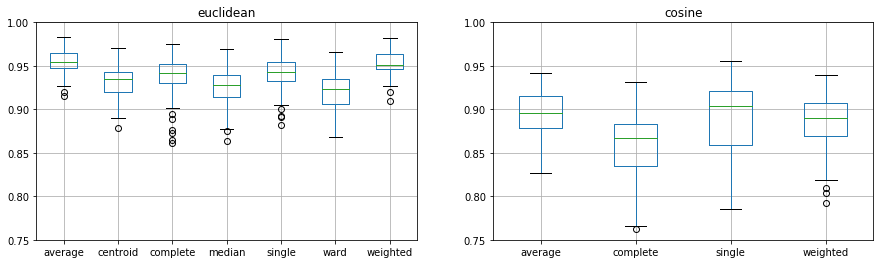

In [68]:
comparison = explore("data_samples/eo1.xml", 1000, True)
plot(comparison)

`comparison` is dictionary, where the keys are the distance metric (euclidean or cosine) and the values are dataframes that compare linkage methods using that distance metric. Because cosine measurements are incompatible with centroid, mean, and ward clustering, those methods have been applied only in the case of Euclidean distance.

### Discussion

Euclidean distance seems to outperform cosine distance consistently. On the other hand, we care only about lower levels of clustering, that is, those that relect rhyme, and not the higher levels, which are artifactual. Meanwhile, much of the variation that is observable in the dendrograms is at those higher (noisy) levels. Since the cophenetic correlation coefficient evalutes the entire clustering result, it isn’t clear (well, to me) whether differences (and especially small differences in values that correspond to clustering differences in the noisy upper levels of the dendrgram) are meaningful.

# Resume here

package dendrogram generation in module for import
import and call to compare dendrograms

### Brjusov, “Voron” (1924)

Translation of Poe, “The raven”. Rhymes are not just pairs.

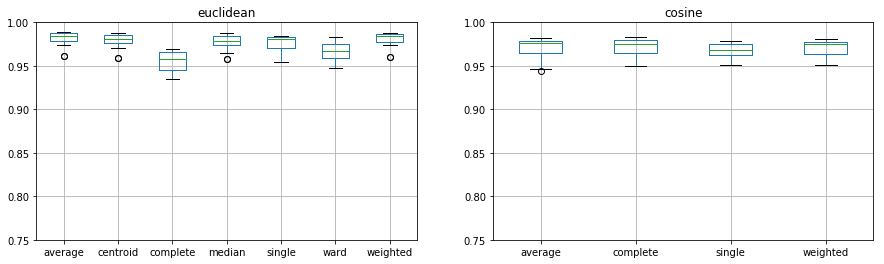

In [69]:
comparison = explore("data_samples/brjusov_voron.xml")
plot(comparison)

## Zinaida Gippius, “Neljubov′” (1907)

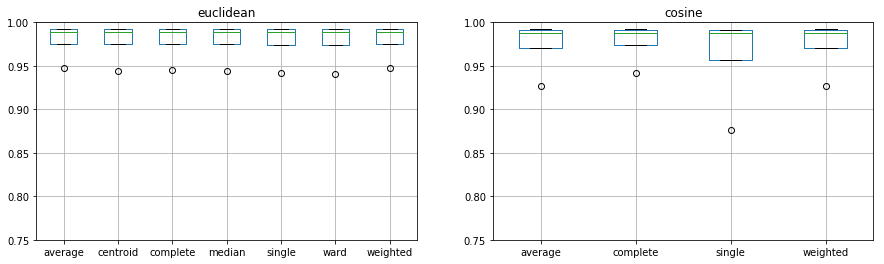

In [70]:
comparison = explore("data_samples/gippius_neljubov.xml")
plot(comparison)

## Anna Axmatova “On ljubil ...” (1910)

* Expect ABC′ABC′e, where the B rhyme is approximate (*[Inaf]* ~ *[InaJ]*). All methods find this except single.
* Line 7 is correctly unpaired, but how can it be recognized as a singleton, and not an approximate rhyme? 
* It isn’t clear why single linkage seems to fail, except that it is known to be buggy in general (<https://github.com/scipy/scipy/issues/7271>). Since it isn’t likely to be the top choice, it doesn’t have any practical consequences.
* Enrichment would be useful for the B rhymes, as would distinctive-feature matching for the pretonic *[p]* ~ *[m]*.

                                                                         Text RhymeWord RhymeZone
       <line lineNo="001">Он любил три вещи на св<stress>е</stress>те:</line>   nasVETi       ETi
 <line lineNo="002">За вечерней пенье, белых павл<stress>и</stress>нов</line>  pavLInaf      Inaf
          <line lineNo="003">И стертые карты Ам<stress>е</stress>рики.</line>   aMERiKi     ERiKi
      <line lineNo="004">Не любил, когда плачут д<stress>е</stress>ти,</line>      DETi       ETi
            <line lineNo="005">Не любил чая с мал<stress>и</stress>ной</line>  smaLInaJ      InaJ
               <line lineNo="006">И женской ист<stress>е</stress>рики.</line>  iSTERiKi     ERiKi
              <line lineNo="007">…А я была его жен<stress>о</stress>й.</line>     žinOJ        OJ


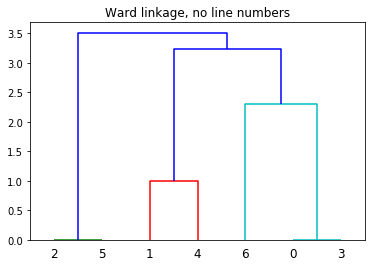

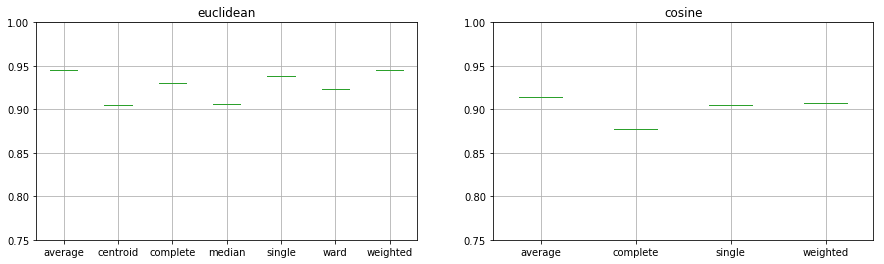

In [97]:
comparison = explore("data_samples/axmatova_on-ljubil.xml", 1000, True, True)
plot(comparison)

## Anna Axmatova, “Pamjati Sergeju Eseninu” (1925)

Finds inexact rhyme of lines 6 and 8 reliably.

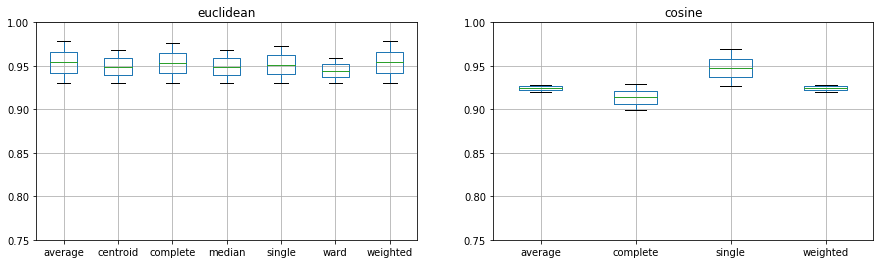

In [54]:
comparison = explore("data_samples/axmatova_pamjati-sergeju-eseninu.xml")
plot(comparison)

## Alexander Sergeevič Puškin, “Prorok” (1826)

{'euclidean':     average  centroid  complete   median    single      ward  weighted
0  0.917071   0.89003  0.885786  0.89226  0.896436  0.827468  0.930289, 'cosine':    average  complete    single  weighted
0  0.84182  0.827207  0.807698  0.856226}


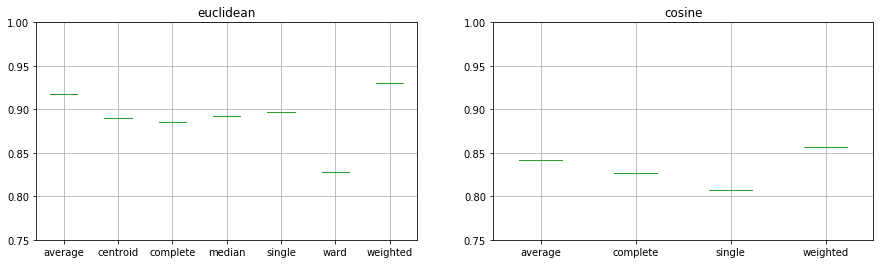

In [56]:
comparison = explore("data_samples/pushkin_prorok.xml",1000,True)
print(comparison)
plot(comparison)